What should this file achieve:
- [x] Select the 3 GeoTiffs with the least cloud cover (while balancing temporal distribution)
- [x] Merge the 3 GeoTiffs into a single GeoTiff
- [x] Split the merged GeoTiff into 256x256 pixel tiles (chips)
- [x] Do the same for the labels
- [x] Ensure the same naming as the original dataset used to traing prithvi
- [x] create 5-Fold split for training and validation/testing
- [x] ~~save the splits as csv files~~ => saved in the filename

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import dvc.api
from rasterio.warp import Resampling
from rasterio.windows import Window

import os
import json
import glob
from datetime import datetime, timedelta

params = dvc.api.params_show()

# Select the three best timesteps

In [2]:
# load all the json from the folder saved_features and create a dataframe

files = []
base_folder = params['paths']['satellite']

for file in os.listdir(base_folder):
        # check whether a file that starts with the same name exists in the folder geotif 
    if file.endswith('.json') and \
        os.path.exists(f"{base_folder}/{file.split('.')[0]}_red.tif"):
        files.append(file)

print('Number of files:', len(files))

jsons = []
for file in files:
    with open(f"{base_folder}/{file}") as f:
        jsons.append(json.load(f))
df = pd.DataFrame(jsons)
df.head()

Number of files: 3


type stac_version                        id  \
0  Feature        1.0.0  S2A_32TMT_20190321_0_L2A   
1  Feature        1.0.0  S2A_32TMT_20190626_1_L2A   
2  Feature        1.0.0  S2B_32TMT_20190929_0_L2A   

                                          properties  \
0  {'created': '2022-11-08T05:15:57.880Z', 'platf...   
1  {'created': '2022-11-08T05:13:55.080Z', 'platf...   
2  {'created': '2022-11-08T05:12:08.147Z', 'platf...   

                                            geometry  \
0  {'type': 'Polygon', 'coordinates': [[[7.662878...   
1  {'type': 'Polygon', 'coordinates': [[[8.114088...   
2  {'type': 'Polygon', 'coordinates': [[[8.122901...   

                                               links  \
0  [{'rel': 'self', 'type': 'application/geo+json...   
1  [{'rel': 'self', 'type': 'application/geo+json...   
2  [{'rel': 'self', 'type': 'application/geo+json...   

                                              assets  \
0  {'aot': {'href': 'https://sentinel-cogs.s3.us-...   
1  {'aot': {'href': 'https://sentinel-cogs.s3.us-...   
2  {'aot': {'href': 'https://sentinel-cogs.s3.us-...   

                                                bbox  \
0  [7.662878883910047, 46.85818510451771, 9.13045...   
1  [7.7542767527327685, 46.85893022810976, 9.1304...   
2  [7.762932333186169, 46.859024108178474, 9.1304...   

                                     stac_extensions      collection  
0  [https://stac-extensions.github.io/raster/v1.1...  sentinel-2-l2a  
1  [https://stac-extensions.github.io/view/v1.0.0...  sentinel-2-l2a  
2  [https://stac-extensions.github.io/grid/v1.0.0...  sentinel-2-l2a

In [3]:
start = datetime.strptime(params['timespans']['start'], '%Y-%m-%d')
end = datetime.strptime(params['timespans']['end'], '%Y-%m-%d')
n_timespans = params['timespans']['number_of_timespans']

days = (end - start).days
days_per_timespan = days // n_timespans

timespans = []
for i in range(n_timespans):
    timespan = {
        "start": start + timedelta(days=days_per_timespan*i),
        "end": start + timedelta(days=days_per_timespan*(i+1))
    }
    timespan['days'] = (timespan['end'] - timespan['start']).days
    timespan['middle'] = timespan['start'] + timedelta(days=timespan['days']//2)
    timespans.append(timespan)

timespans

[{'start': datetime.datetime(2019, 3, 1, 0, 0),
  'end': datetime.datetime(2019, 5, 11, 0, 0),
  'days': 71,
  'middle': datetime.datetime(2019, 4, 5, 0, 0)},
 {'start': datetime.datetime(2019, 5, 11, 0, 0),
  'end': datetime.datetime(2019, 7, 21, 0, 0),
  'days': 71,
  'middle': datetime.datetime(2019, 6, 15, 0, 0)},
 {'start': datetime.datetime(2019, 7, 21, 0, 0),
  'end': datetime.datetime(2019, 9, 30, 0, 0),
  'days': 71,
  'middle': datetime.datetime(2019, 8, 25, 0, 0)}]

In [4]:
df.iloc[0].properties

{'created': '2022-11-08T05:15:57.880Z',
 'platform': 'sentinel-2a',
 'constellation': 'sentinel-2',
 'instruments': ['msi'],
 'eo:cloud_cover': 1.619651,
 'proj:epsg': 32632,
 'mgrs:utm_zone': 32,
 'mgrs:latitude_band': 'T',
 'mgrs:grid_square': 'MT',
 'grid:code': 'MGRS-32TMT',
 'view:sun_azimuth': 161.240716302973,
 'view:sun_elevation': 41.3020172296403,
 's2:degraded_msi_data_percentage': 0,
 's2:nodata_pixel_percentage': 0.000892,
 's2:saturated_defective_pixel_percentage': 0,
 's2:dark_features_percentage': 4.386146,
 's2:cloud_shadow_percentage': 0.890805,
 's2:vegetation_percentage': 65.313649,
 's2:not_vegetated_percentage': 13.903943,
 's2:water_percentage': 3.666477,
 's2:unclassified_percentage': 2.203596,
 's2:medium_proba_clouds_percentage': 0.92041,
 's2:high_proba_clouds_percentage': 0.074738,
 's2:thin_cirrus_percentage': 0.624502,
 's2:snow_ice_percentage': 8.015728,
 's2:product_type': 'S2MSI2A',
 's2:processing_baseline': '02.11',
 's2:product_uri': 'S2A_MSIL2A_2019

In [5]:
# parse .properties['datetime'] and add it to the dataframe
df['datetime'] = pd.to_datetime(df['properties'].apply(lambda x: datetime.strptime(x['datetime'], '%Y-%m-%dT%H:%M:%S.%fZ')))
df["cloud_cover"] = df["properties"].apply(lambda x: x["eo:cloud_cover"] / 100)
df.head(3)

type stac_version                        id  \
0  Feature        1.0.0  S2A_32TMT_20190321_0_L2A   
1  Feature        1.0.0  S2A_32TMT_20190626_1_L2A   
2  Feature        1.0.0  S2B_32TMT_20190929_0_L2A   

                                          properties  \
0  {'created': '2022-11-08T05:15:57.880Z', 'platf...   
1  {'created': '2022-11-08T05:13:55.080Z', 'platf...   
2  {'created': '2022-11-08T05:12:08.147Z', 'platf...   

                                            geometry  \
0  {'type': 'Polygon', 'coordinates': [[[7.662878...   
1  {'type': 'Polygon', 'coordinates': [[[8.114088...   
2  {'type': 'Polygon', 'coordinates': [[[8.122901...   

                                               links  \
0  [{'rel': 'self', 'type': 'application/geo+json...   
1  [{'rel': 'self', 'type': 'application/geo+json...   
2  [{'rel': 'self', 'type': 'application/geo+json...   

                                              assets  \
0  {'aot': {'href': 'https://sentinel-cogs.s3.us-...   
1  {'aot': {'href': 'https://sentinel-cogs.s3.us-...   
2  {'aot': {'href': 'https://sentinel-cogs.s3.us-...   

                                                bbox  \
0  [7.662878883910047, 46.85818510451771, 9.13045...   
1  [7.7542767527327685, 46.85893022810976, 9.1304...   
2  [7.762932333186169, 46.859024108178474, 9.1304...   

                                     stac_extensions      collection  \
0  [https://stac-extensions.github.io/raster/v1.1...  sentinel-2-l2a   
1  [https://stac-extensions.github.io/view/v1.0.0...  sentinel-2-l2a   
2  [https://stac-extensions.github.io/grid/v1.0.0...  sentinel-2-l2a   

                 datetime  cloud_cover  
0 2019-03-21 10:50:45.062     0.016197  
1 2019-06-26 10:27:53.444     0.047817  
2 2019-09-29 10:27:49.362     0.036119

In [6]:
assert params['timespans']['number_of_timespans'] == 3 # Hack: do later when needed

df['timespan_1'] = df['datetime'].apply(lambda x: timespans[0]['start'] <= x < timespans[0]['end'])
df['timespan_2'] = df['datetime'].apply(lambda x: timespans[1]['start'] <= x < timespans[1]['end'])
df['timespan_3'] = df['datetime'].apply(lambda x: timespans[2]['start'] <= x < timespans[2]['end'])

# for each timespan, get the number of days from the middle of the timespan to the date of the image
df['days_from_middle'] = float('nan')
df.loc[df['timespan_1'], 'days_from_middle'] = df.loc[df['timespan_1'], 'datetime'].apply(lambda x: abs((timespans[0]['middle'] - x).days))
df.loc[df['timespan_2'], 'days_from_middle'] = df.loc[df['timespan_2'], 'datetime'].apply(lambda x: abs((timespans[1]['middle'] - x).days))
df.loc[df['timespan_3'], 'days_from_middle'] = df.loc[df['timespan_3'], 'datetime'].apply(lambda x: abs((timespans[2]['middle'] - x).days))

df.sample(3)

type stac_version                        id  \
1  Feature        1.0.0  S2A_32TMT_20190626_1_L2A   
0  Feature        1.0.0  S2A_32TMT_20190321_0_L2A   
2  Feature        1.0.0  S2B_32TMT_20190929_0_L2A   

                                          properties  \
1  {'created': '2022-11-08T05:13:55.080Z', 'platf...   
0  {'created': '2022-11-08T05:15:57.880Z', 'platf...   
2  {'created': '2022-11-08T05:12:08.147Z', 'platf...   

                                            geometry  \
1  {'type': 'Polygon', 'coordinates': [[[8.114088...   
0  {'type': 'Polygon', 'coordinates': [[[7.662878...   
2  {'type': 'Polygon', 'coordinates': [[[8.122901...   

                                               links  \
1  [{'rel': 'self', 'type': 'application/geo+json...   
0  [{'rel': 'self', 'type': 'application/geo+json...   
2  [{'rel': 'self', 'type': 'application/geo+json...   

                                              assets  \
1  {'aot': {'href': 'https://sentinel-cogs.s3.us-...   
0  {'aot': {'href': 'https://sentinel-cogs.s3.us-...   
2  {'aot': {'href': 'https://sentinel-cogs.s3.us-...   

                                                bbox  \
1  [7.7542767527327685, 46.85893022810976, 9.1304...   
0  [7.662878883910047, 46.85818510451771, 9.13045...   
2  [7.762932333186169, 46.859024108178474, 9.1304...   

                                     stac_extensions      collection  \
1  [https://stac-extensions.github.io/view/v1.0.0...  sentinel-2-l2a   
0  [https://stac-extensions.github.io/raster/v1.1...  sentinel-2-l2a   
2  [https://stac-extensions.github.io/grid/v1.0.0...  sentinel-2-l2a   

                 datetime  cloud_cover  timespan_1  timespan_2  timespan_3  \
1 2019-06-26 10:27:53.444     0.047817       False        True       False   
0 2019-03-21 10:50:45.062     0.016197        True       False       False   
2 2019-09-29 10:27:49.362     0.036119       False       False        True   

   days_from_middle  
1              12.0  
0              14.0  
2              36.0

In [7]:
assert params['timespans']['number_of_timespans'] == 3 # Hack: do later when needed

df['timespan_1'].sum(), df['timespan_2'].sum(), df['timespan_3'].sum()

(1, 1, 1)

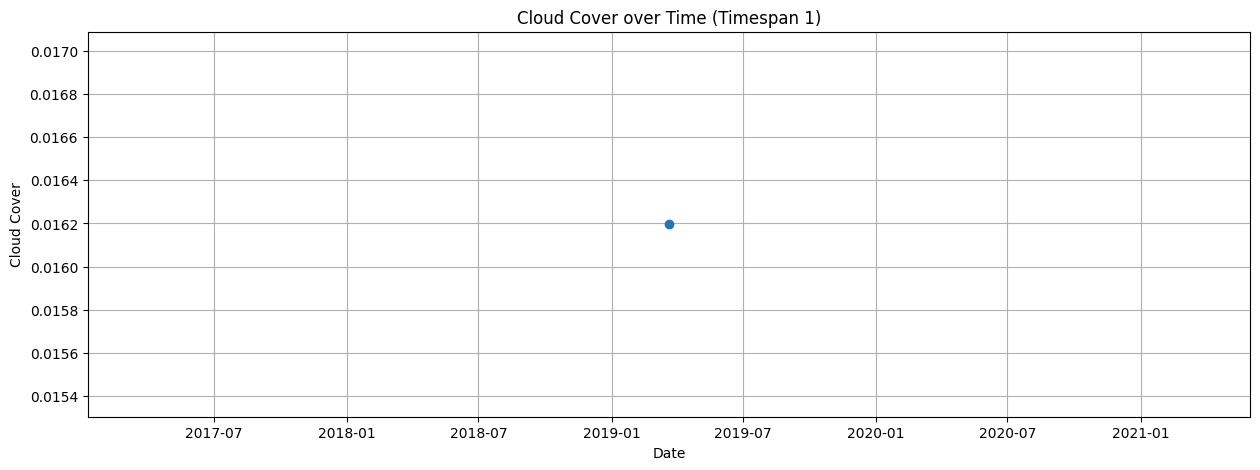

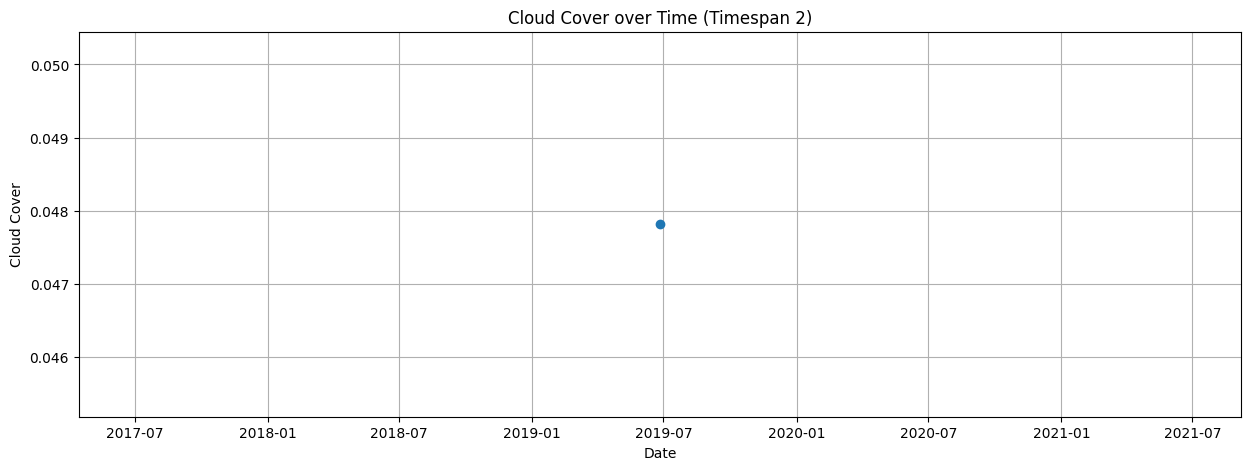

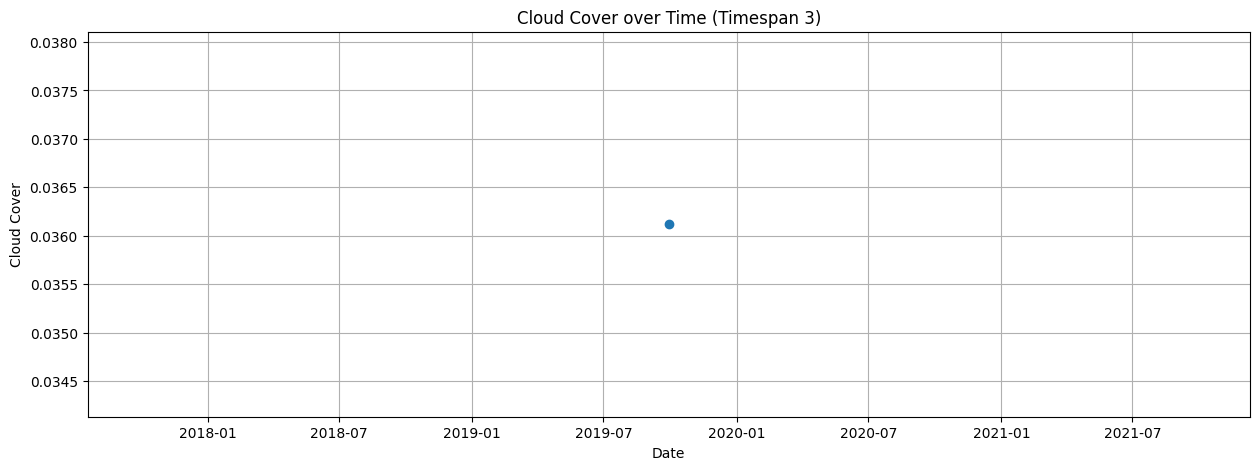

In [8]:
assert params['timespans']['number_of_timespans'] == 3 # Hack: do later when needed
# for each timespan, get the cloud cover and the dates
# then visualize the cloud cover over time

def visualize_cloud_cover(timespan, title):
    # order timespan by datetime
    timespan = timespan.sort_values(by='datetime')
    plt.figure(figsize=(15, 5))
    plt.plot(timespan['datetime'], timespan['cloud_cover'], 'o-')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Cloud Cover')
    plt.grid()
    plt.show()

visualize_cloud_cover(df[df['timespan_1']], 'Cloud Cover over Time (Timespan 1)')
visualize_cloud_cover(df[df['timespan_2']], 'Cloud Cover over Time (Timespan 2)')
visualize_cloud_cover(df[df['timespan_3']], 'Cloud Cover over Time (Timespan 3)')

In [9]:
# for each timespan, get the date with the lowest cloud cover and minimal distance from the middle of the timespan

def get_best_image(df_timespan):
    # order by middle distance
    df_timespan = df_timespan.sort_values(by=['cloud_cover', 'days_from_middle'])
#    display(df_timespan.head())
    return df_timespan.iloc[0]

best_images = []
for i in range(1, n_timespans+1):
    best_images.append(get_best_image(df[df[f'timespan_{i}']]))
    best_images[-1]['timespan'] = i
best_images = pd.DataFrame(best_images)
best_images

type stac_version                        id  \
0  Feature        1.0.0  S2A_32TMT_20190321_0_L2A   
1  Feature        1.0.0  S2A_32TMT_20190626_1_L2A   
2  Feature        1.0.0  S2B_32TMT_20190929_0_L2A   

                                          properties  \
0  {'created': '2022-11-08T05:15:57.880Z', 'platf...   
1  {'created': '2022-11-08T05:13:55.080Z', 'platf...   
2  {'created': '2022-11-08T05:12:08.147Z', 'platf...   

                                            geometry  \
0  {'type': 'Polygon', 'coordinates': [[[7.662878...   
1  {'type': 'Polygon', 'coordinates': [[[8.114088...   
2  {'type': 'Polygon', 'coordinates': [[[8.122901...   

                                               links  \
0  [{'rel': 'self', 'type': 'application/geo+json...   
1  [{'rel': 'self', 'type': 'application/geo+json...   
2  [{'rel': 'self', 'type': 'application/geo+json...   

                                              assets  \
0  {'aot': {'href': 'https://sentinel-cogs.s3.us-...   
1  {'aot': {'href': 'https://sentinel-cogs.s3.us-...   
2  {'aot': {'href': 'https://sentinel-cogs.s3.us-...   

                                                bbox  \
0  [7.662878883910047, 46.85818510451771, 9.13045...   
1  [7.7542767527327685, 46.85893022810976, 9.1304...   
2  [7.762932333186169, 46.859024108178474, 9.1304...   

                                     stac_extensions      collection  \
0  [https://stac-extensions.github.io/raster/v1.1...  sentinel-2-l2a   
1  [https://stac-extensions.github.io/view/v1.0.0...  sentinel-2-l2a   
2  [https://stac-extensions.github.io/grid/v1.0.0...  sentinel-2-l2a   

                 datetime  cloud_cover  timespan_1  timespan_2  timespan_3  \
0 2019-03-21 10:50:45.062     0.016197        True       False       False   
1 2019-06-26 10:27:53.444     0.047817       False        True       False   
2 2019-09-29 10:27:49.362     0.036119       False       False        True   

   days_from_middle  timespan  
0              14.0         1  
1              12.0         2  
2              36.0         3

In [10]:
assert params['timespans']['number_of_timespans'] == 3 # Hack: do later when needed
# get the distance between the best images
print('Distance between best images 1 and 2:', abs((best_images[best_images['timespan'] == 1]['datetime'].values[0] - best_images[best_images['timespan'] == 2]['datetime'].values[0]).astype('timedelta64[D]').astype(int)))
print('Distance between best images 2 and 3:', abs((best_images[best_images['timespan'] == 2]['datetime'].values[0] - best_images[best_images['timespan'] == 3]['datetime'].values[0]).astype('timedelta64[D]').astype(int)))

Distance between best images 1 and 2: 97
Distance between best images 2 and 3: 95


# Load the three best GeoTiffs

In [11]:
# files are located at data/satellite\S2B_32TMT_20190604_0_L2A_nir.tif
# append filenames as list to the best_images dataframe
best_images['filename'] = best_images['id'].apply(lambda x: {channel: f"{params['paths']['satellite']}/{x}_{channel}.tif" for channel in ['red', 'green', 'blue', 'nir', 'swir16', 'swir22']})

# load the images
images = []
for i in range(len(best_images)):
    print(f'date: {best_images[best_images.timespan == i+1]["datetime"].values[0]}')
    channels = {}
    for channel, filename in best_images[best_images.timespan == i+1]['filename'].values[0].items():
        with rasterio.open(filename) as src:
            channels[channel] = {
                "data": src.read(1),
                "profile": src.profile,
                "path": filename
            }
    images.append(channels)

# print the first profile
images[0]['red']['profile']

date: 2019-03-21T10:50:45.062000000
date: 2019-06-26T10:27:53.444000000
date: 2019-09-29T10:27:49.362000000


{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 5120, 'height': 5120, 'count': 1, 'crs': CRS.from_epsg(32632), 'transform': Affine(10.0, 0.0, 451864.75251478504,
       0.0, -10.0, 5283035.4233372435), 'blockysize': 1, 'tiled': False, 'interleave': 'band'}

In [12]:
# check whether transform and crs are the same
for i in range(1, len(images)):
    for channel in images[0]:
        assert images[0][channel].get('profile')['transform'] == images[i][channel].get('profile')['transform']
        assert images[0][channel].get('profile')['crs'] == images[i][channel].get('profile')['crs']
        assert images[0][channel].get('profile')['width'] == images[i][channel].get('profile')['width']
        assert images[0][channel].get('profile')['height'] == images[i][channel].get('profile')['height']

In [13]:
channels = ['red', 'green', 'blue', 'nir', 'swir16', 'swir22']
# print height, width and dtype of each channel
for channel in channels:
    print(f'{channel}: height={images[0][channel].get("profile")["height"]}, width={images[0][channel].get("profile")["width"]}, dtype={images[0][channel].get("data").dtype}')

red: height=5120, width=5120, dtype=uint16
green: height=5120, width=5120, dtype=uint16
blue: height=5120, width=5120, dtype=uint16
nir: height=5120, width=5120, dtype=uint16
swir16: height=2560, width=2560, dtype=uint16
swir22: height=2560, width=2560, dtype=uint16


In [14]:
# File paths
file_paths = tiff_files = [images[i][channel]['path'] for i in range(len(images)) for channel in channels]

reference_profile = images[0]['red']['profile']
target_height    = reference_profile['height']
target_width     = reference_profile['width']
target_crs       = reference_profile['crs']
target_transform = reference_profile['transform']

# Define metadata for the output file
meta = {
    'driver': 'GTiff',
    'dtype': 'uint16',
    'width': target_width,
    'height': target_height,
    'count': len(file_paths),
    'crs': target_crs,
    'transform': target_transform
}

# Resample each GeoTIFF to the target grid
layers = []

for path in file_paths:
    with rasterio.open(path) as src:
        data = src.read(1, out_shape=(target_height, target_width), resampling=Resampling.bilinear,
                        out_dtype=meta['dtype'])
        layers.append(data)

# Write to output
with rasterio.open(params['paths']['stacked_features'], 'w', **meta) as dst:
    for i, layer in enumerate(layers, start=1):
        dst.write(layer, indexes=i)
        # print the center coordinates of the image


print(f"Stacking complete. Output saved as '{params['paths']['stacked_features']}'")

Stacking complete. Output saved as 'data/stacked_features.tif'


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


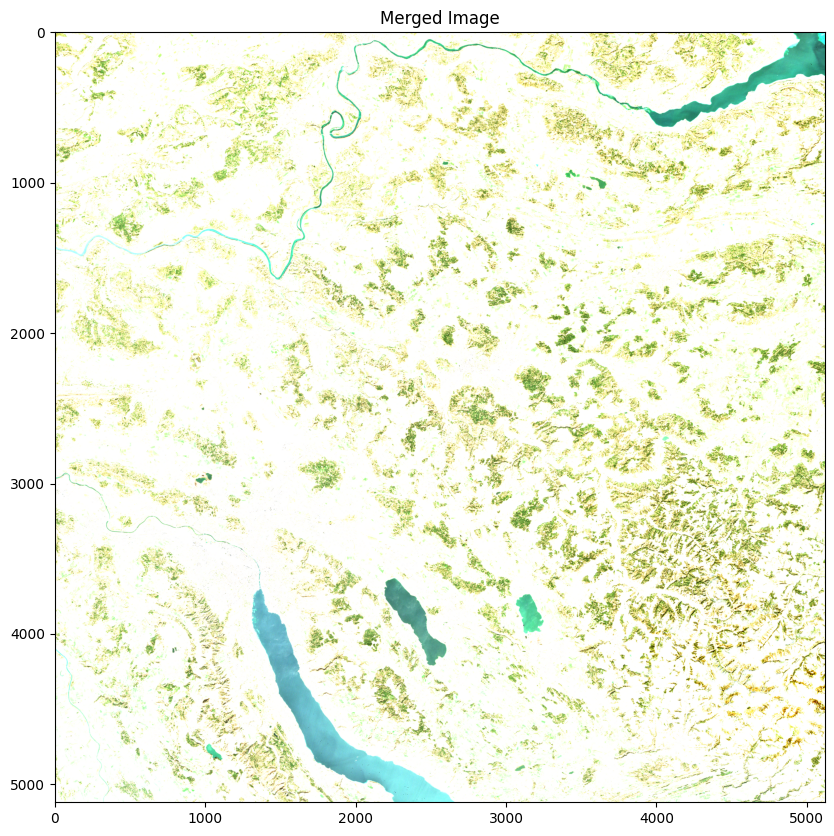

In [15]:
# read the merged image and print the metadata
with rasterio.open(params['paths']['stacked_features']) as src:
    plt.figure(figsize=(10, 10))
    # read the first 3 bands
    img = src.read([1, 2, 3])
    plt.imshow(img.transpose(1, 2, 0))
    plt.title('Merged Image')

works!!!!

# Split into Chips by one Band for each Fold

This section is only relevant if the `fold_split_mode='band'` is used. In this case, the chips are split by band and not stratified by classes.

In [2]:
CHIP_SIZE = params['chip_size']
NUMBER_OF_FOLDS = params['number_of_folds']
SPLIT_MODE = params['fold_split_mode']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of tiles: (22, 22)
Number of usable tiles: 22
Number of pixels to remove on each side: 96
Number of tiles per 6 fold: 3.6666666666666665, 4.4


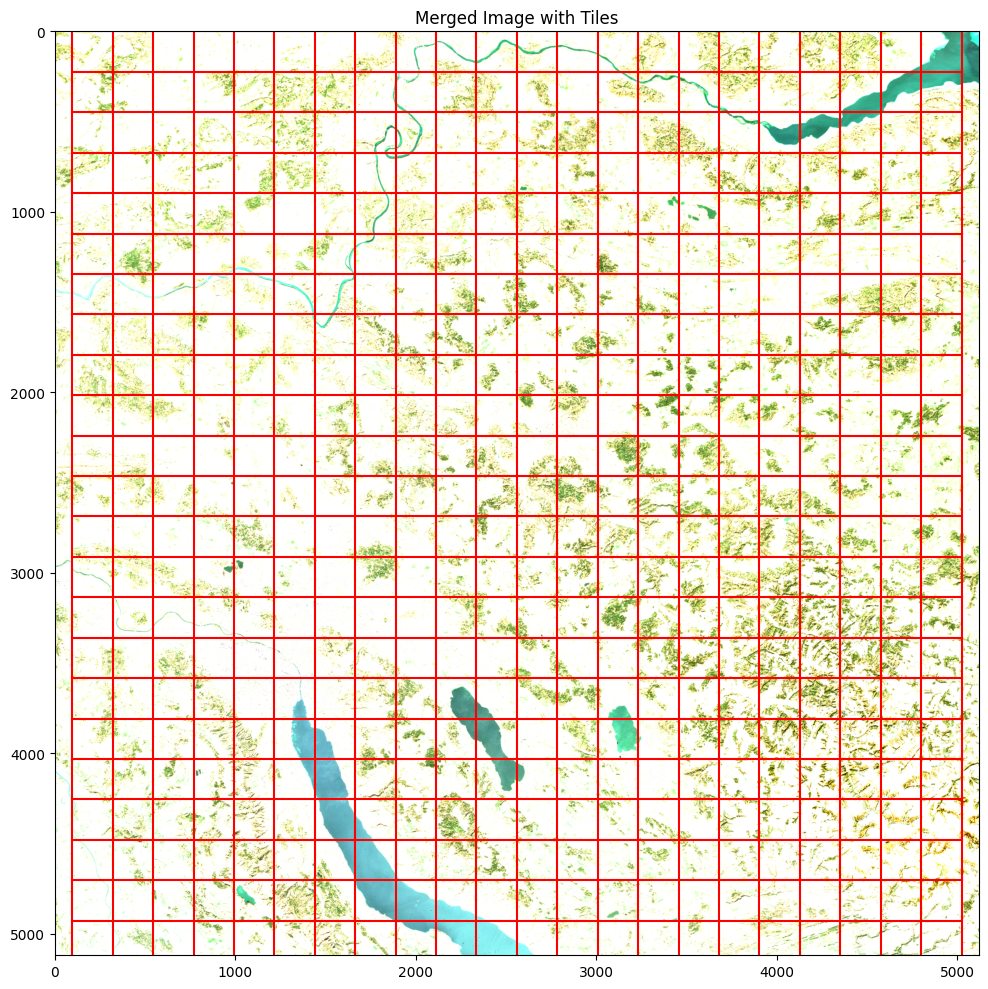

In [9]:
pixels_to_remove_on_each_side = 0

with rasterio.open(params['paths']['stacked_features']) as src:
    plt.figure(figsize=(10, 10))
    img = src.read([1, 2, 3])
    plt.imshow(img.transpose(1, 2, 0))
    number_of_tiles = (src.width // CHIP_SIZE, src.height // CHIP_SIZE)
    number_of_usable_tiles = (number_of_tiles[0] // NUMBER_OF_FOLDS) * NUMBER_OF_FOLDS if SPLIT_MODE == 'band' else number_of_tiles[0]
    number_of_pixels_to_remove = src.width - number_of_usable_tiles * CHIP_SIZE
    pixels_to_remove_on_each_side = number_of_pixels_to_remove // 2
    print(f'Number of tiles: {number_of_tiles}')
    print(f'Number of usable tiles: {number_of_usable_tiles}')
    print(f'Number of pixels to remove on each side: {pixels_to_remove_on_each_side}')
    print(f"Number of tiles per {NUMBER_OF_FOLDS} fold: {number_of_tiles[0] / NUMBER_OF_FOLDS}")
    
    
    for i in range(pixels_to_remove_on_each_side, src.width, CHIP_SIZE):
        if i >= (pixels_to_remove_on_each_side + (number_of_usable_tiles+1)*CHIP_SIZE):
            continue
        plt.axvline(i, color='r')
    for i in range(0, src.height, CHIP_SIZE):
        plt.plot([pixels_to_remove_on_each_side, src.height-pixels_to_remove_on_each_side], [i, i], color='r')
    if SPLIT_MODE == 'band':
        for i in range(pixels_to_remove_on_each_side, src.width, CHIP_SIZE * (number_of_tiles[0] // NUMBER_OF_FOLDS)):
            plt.axvline(i, color='g', linewidth=4)
            if i >= (pixels_to_remove_on_each_side + (number_of_tiles[0] // NUMBER_OF_FOLDS)*NUMBER_OF_FOLDS*CHIP_SIZE):
                continue
            plt.text(i + CHIP_SIZE * ((number_of_tiles[0] // NUMBER_OF_FOLDS) // 2 - 1), src.height // 2 - 0.25 * CHIP_SIZE, f"Fold {i // (CHIP_SIZE * (number_of_tiles[0] // NUMBER_OF_FOLDS))}", color='b', fontsize=24)
    plt.title('Merged Image with Tiles')
    plt.tight_layout()
    plt.show()

In [4]:
def split_raster_into_chips_by_band(raster_file, filename_postfix='merged'):
    with rasterio.open(raster_file) as src:
        number_of_tiles = (src.width // CHIP_SIZE, src.height // CHIP_SIZE)
        number_of_tiles_per_fold = number_of_tiles[0] // NUMBER_OF_FOLDS
        number_of_usable_tiles = (number_of_tiles[0] // NUMBER_OF_FOLDS) * NUMBER_OF_FOLDS
        number_of_pixels_to_remove = src.width - number_of_usable_tiles * CHIP_SIZE
        pixels_to_remove_on_each_side = number_of_pixels_to_remove // 2

        for i in range(number_of_tiles[0]):
            fold = i // number_of_tiles_per_fold
            if fold >= NUMBER_OF_FOLDS: # skip the last non-complete fold
                continue

            for j in range(number_of_tiles[1]):
                window = Window(pixels_to_remove_on_each_side + i * CHIP_SIZE, j * CHIP_SIZE, CHIP_SIZE, CHIP_SIZE)
            
                data = src.read(window=window)
            
                profile = src.profile
                profile.update({
                    'width': CHIP_SIZE,
                    'height': CHIP_SIZE,
                    'transform': rasterio.windows.transform(window, src.transform)
                })

                filename = f"._chip_{i:>03}_{j:>03}_fold_{fold}_{filename_postfix}.tif"
                with rasterio.open(f"{params['paths']['chips']}/{filename}", 'w', **profile) as dst:
                    dst.write(data)

if SPLIT_MODE == 'band':
    os.makedirs(params['paths']['chips'], exist_ok=True)
    split_raster_into_chips_by_band(params['paths']['stacked_features'], 'merged')
    split_raster_into_chips_by_band(params['paths']['labels_hierarchy'], 'mask')
    split_raster_into_chips_by_band(params['paths']['field_ids'], 'field_ids')
    

In [ ]:
# read all mask and check whether the mask is empty
if SPLIT_MODE == 'band':
    n_empty = 0
    filenames_empty = []

    mask_files = glob.glob(f"{params['paths']['chips']}/._chip_*_fold_*_mask.tif")
    for mask_file in mask_files:
        with rasterio.open(mask_file) as src:
            mask = src.read(1)
            n_unique = np.unique(mask)
            if len(n_unique) == 1 and n_unique[0] == 0:
                n_empty += 1
                filenames_empty.append(mask_file)
    print(f'Number of empty masks: {n_empty}')

Number of empty masks: 55


In [ ]:
# remove the empty masks and the corresponding chips
if SPLIT_MODE == 'band':
    for filename in filenames_empty:
        os.remove(filename)
        os.remove(filename.replace('mask', 'merged'))
        os.remove(filename.replace('mask', 'field_ids'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of tiles: (22, 22)
Number of usable tiles: 18
Number of pixels to remove on each side: 544
Number of tiles per 6 fold: 3.6666666666666665, 4.4


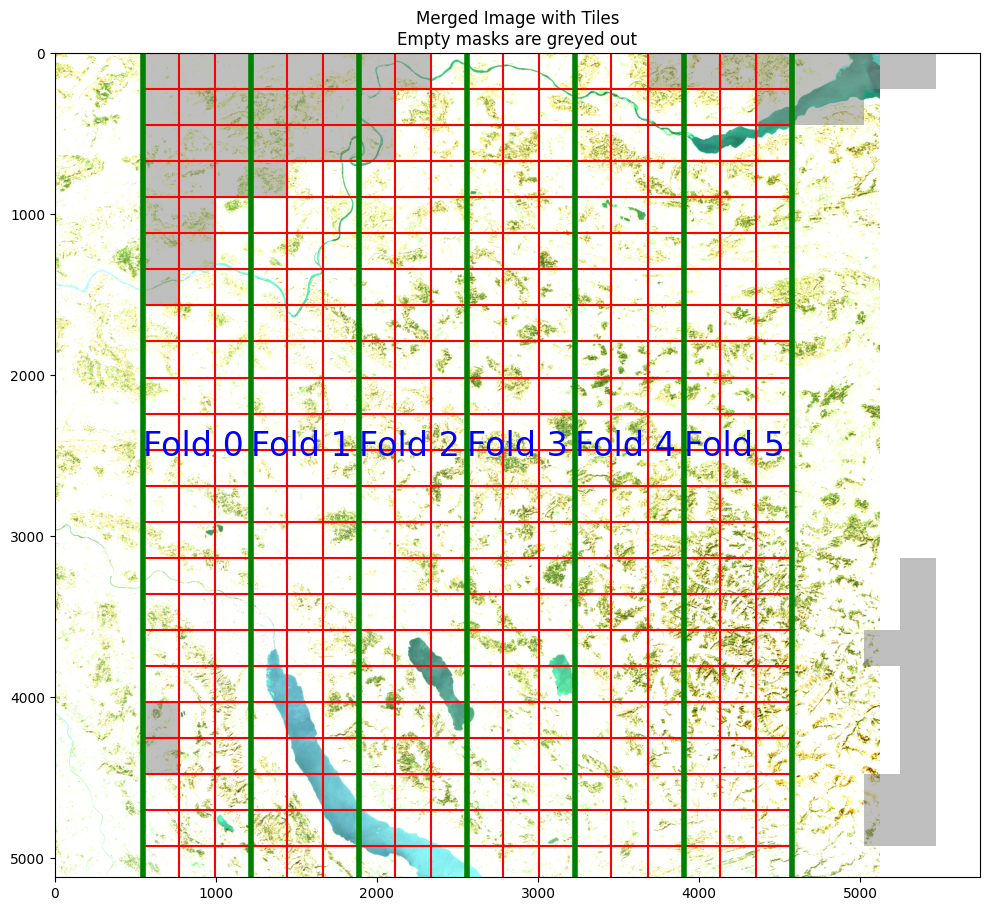

In [ ]:
if SPLIT_MODE == 'band':
    with rasterio.open(params['paths']['stacked_features']) as src:
        plt.figure(figsize=(10, 10))
        img = src.read([1, 2, 3])
        plt.imshow(img.transpose(1, 2, 0))
        number_of_tiles = (src.width // CHIP_SIZE, src.height // CHIP_SIZE)
        number_of_usable_tiles = (number_of_tiles[0] // NUMBER_OF_FOLDS) * NUMBER_OF_FOLDS
        number_of_pixels_to_remove = src.width - number_of_usable_tiles * CHIP_SIZE
        pixels_to_remove_on_each_side = number_of_pixels_to_remove // 2
        print(f'Number of tiles: {number_of_tiles}')
        print(f'Number of usable tiles: {number_of_usable_tiles}')
        print(f'Number of pixels to remove on each side: {pixels_to_remove_on_each_side}')
        print(f"Number of tiles per {NUMBER_OF_FOLDS} fold: {number_of_tiles[0] / NUMBER_OF_FOLDS}, {number_of_tiles[1] / 5}")
        
        
        for i in range(pixels_to_remove_on_each_side, src.width, CHIP_SIZE):
            if i >= (pixels_to_remove_on_each_side + number_of_usable_tiles*CHIP_SIZE):
                continue
            plt.axvline(i, color='r')
        for i in range(0, src.height, CHIP_SIZE):
            plt.plot([pixels_to_remove_on_each_side, src.height-pixels_to_remove_on_each_side], [i, i], color='r')
        for i in range(pixels_to_remove_on_each_side, src.width, CHIP_SIZE * (number_of_tiles[0] // NUMBER_OF_FOLDS)):
            plt.axvline(i, color='g', linewidth=4)
            if i >= (pixels_to_remove_on_each_side + (number_of_tiles[0] // NUMBER_OF_FOLDS)*NUMBER_OF_FOLDS*CHIP_SIZE):
                continue
            plt.text(i + CHIP_SIZE * ((number_of_tiles[0] // NUMBER_OF_FOLDS) // 2 - 1), src.height // 2 - 0.25 * CHIP_SIZE, f"Fold {i // (CHIP_SIZE * (number_of_tiles[0] // NUMBER_OF_FOLDS))}", color='b', fontsize=24)
        # grey out all empty masks
        for filename in filenames_empty:
            i, j = int(filename.split('_')[2]), int(filename.split('_')[3])
            plt.fill([pixels_to_remove_on_each_side+i*CHIP_SIZE, pixels_to_remove_on_each_side+(i+1)*CHIP_SIZE-1, pixels_to_remove_on_each_side+(i+1)*CHIP_SIZE-1, pixels_to_remove_on_each_side+i*CHIP_SIZE], 
                    [j*CHIP_SIZE, j*CHIP_SIZE, (j+1)*CHIP_SIZE-1, (j+1)*CHIP_SIZE-1], 'grey', alpha=0.5)

        plt.title('Merged Image with Tiles\n'
                'Empty masks are greyed out')
        plt.tight_layout()
        plt.show()


In [ ]:
# ensure that for each chip there is a corresponding mask
if SPLIT_MODE == 'band':
    chips = [f for f in os.listdir(params['paths']['chips']) if f.endswith('merged.tif')]
    masks = [f for f in os.listdir(params['paths']['chips']) if f.endswith('mask.tif')]
    field_ids = [f for f in os.listdir(params['paths']['chips']) if f.endswith('field_ids.tif')]

    chips.sort()
    masks.sort()
    field_ids.sort()

    print(len(chips), len(masks), len(field_ids))
    assert len(chips) == len(masks)
    assert len(chips) == len(field_ids)

    for chip, mask, field_id in zip(chips, masks, field_ids):
        assert chip.split('_')[2] == mask.split('_')[2]
        assert chip.split('_')[3] == mask.split('_')[3]
        
        assert chip.split('_')[2] == field_id.split('_')[2]
        assert chip.split('_')[3] == field_id.split('_')[3]

369 369 369


# Split into Chips stratified

In [3]:
def read_chips(raster_file, include_class_distribution=False):
    """
    Reads all the chips and returns the data along with the profile of the raster file.

    Args:
    raster_file (str): The path to the raster file.

    Returns:
    data (list): A list containing a dict with the data, profile and optionally the class distribution of each chip.
    """
    with rasterio.open(raster_file) as src:
        number_of_tiles = (src.width // CHIP_SIZE, src.height // CHIP_SIZE)
        number_of_pixels_to_remove = src.width - number_of_tiles[0] * CHIP_SIZE
        pixels_to_remove_on_each_side = number_of_pixels_to_remove // 2

        chips = []
        for i in range(number_of_tiles[0]):
            for j in range(number_of_tiles[1]):
                window = Window(pixels_to_remove_on_each_side + i * CHIP_SIZE, j * CHIP_SIZE, CHIP_SIZE, CHIP_SIZE)
                data = src.read(window=window)
                profile = src.profile
                profile.update({
                    'width': CHIP_SIZE,
                    'height': CHIP_SIZE,
                    'transform': rasterio.windows.transform(window, src.transform)
                })
                if not include_class_distribution:
                    chips.append({
                        'i': i,
                        'j': j,
                        'data': data,
                        'profile': profile
                        })
                else:
                    # count the unique values in the chip data
                    lowest_tier = data[-1]
                    unique, counts = np.unique(lowest_tier, return_counts=True)
                    class_distribution = dict(zip(unique, counts))
                    chips.append({
                        'i': i,
                        'j': j,
                        'data': data,
                        'profile': profile,
                        'class_distribution': class_distribution
                        })
        return chips

In [22]:
def create_stratified_folds(mask_class_distributions, n_folds=5, transform_mode=None, alpha=1/10, debug=False):
    """
    Create stratified folds based on pixel class distribution.

    This function uses Kullback-Leibler (KL) Divergence to measure the difference between the true class distribution.
    And uses a heuristic to approximate the optimal fold distribution (analogous to the forward selection algorithm in linear regression when choosing features).

    First, each fold is initialized with one random chip.
    Then, for each chip, the KL divergence is calculated between the true class distribution and the class distribution of each fold (if the chip is added to that fold).
    The chip is then added to the fold that creates the overall smallest KL divergence.
    This is repeated until all chips are assigned to a fold.
    
    :param mask_class_distributions: List of dictionaries with class distribution for each image
    :param n_folds: Number of folds to create
    :param transform_mode: How to transform the pixel counts before 
    :param alpha: Hyperparameter that controls how much influence penalty has.

    :return: List of fold indices for each image
    """
    n_classes = max([max(mask_class_dist.keys()) for mask_class_dist in mask_class_distributions]) + 1
    n_chips = len(mask_class_distributions)
    image_pixel_counts = np.zeros((n_chips, n_classes))
    
    for i, class_dist in enumerate(mask_class_distributions):
        for clazz, count in class_dist.items():
            image_pixel_counts[i, clazz] = count


    def kl_divergence(p, q):
        """
        Calculate the Kullback-Leibler Divergence between two distributions.

        :param p: True Distribution P (numpy array, shape (n_classes,), summing to 1)
        :param q: Observed Distribution Q (numpy array, shape (n_classes,), summing to 1)
        
        :return: KL Divergence between P and Q
        """
        return np.sum(p * np.log(p / q))
    
    def score_distributions(overall_pixel_count, fold_pixel_counts, alpha):
        """
        Calculate the average KL divergence between the true distribution and all observed distributions.
        
        :param overall_pixel_count: Total pixel count for each class across all images. (numpy array, shape (n_classes,))
        :param fold_pixel_counts: Pixel count for each class in each fold. (numpy array, shape (n_folds, n_classes))
        :param alpha: Hyperparameter that controls how much influence penalty has. 

        :return: Average KL Divergence between the true distribution and all observed distributions.
        """
        if transform_mode is None or transform_mode == 'none' or transform_mode == 'None':
            transform = lambda x: x + 1 # division by 0
        elif transform_mode == 'log':
            transform = lambda x: np.log(x + 1) + 0.1 # division by 0
        elif transform_mode == 'sqrt':
            transform = lambda x: np.sqrt(x) + 0.1 # division by 0

        overall_pixel_count = transform(overall_pixel_count)
        fold_pixel_counts = transform(fold_pixel_counts)

        p = overall_pixel_count / np.sum(overall_pixel_count)
        qs = fold_pixel_counts / np.sum(fold_pixel_counts, axis=1, keepdims=True)

        mean_kl_divergence = np.mean([kl_divergence(p, q) for q in qs])
        pixel_count_per_fold = np.sum(fold_pixel_counts, axis=1) # (n_folds,)
        unequal_pixel_count_penalty = np.sqrt(np.sum((np.mean(pixel_count_per_fold)-pixel_count_per_fold)**2))

        return mean_kl_divergence + alpha * unequal_pixel_count_penalty

    total_pixel_counts = np.sum(image_pixel_counts, axis=0)

    fold_pixel_counts = np.zeros((n_folds, n_classes))
    fold_indices = np.full(n_chips, -1, dtype=int) # init with -1 to indicate that no fold has been assigned

    # Initialize each fold with a random chip
    for i in range(n_folds):
        # TODO this should be random but still somehow deterministic
        fold_indices[i] = i
        fold_pixel_counts[i] = image_pixel_counts[i]

    # for each remaining chip, assign a fold such that the kl-divergence gets minimized in each step
    for i in range(n_folds, n_chips):
        new_fold_pixel_counts = fold_pixel_counts.copy()
        scores = np.full((n_chips, n_folds), np.inf, dtype=np.float32)
        alpha = 1 / (30*np.sqrt(n_chips-i+1))
        # ALPHA hyperparameter analysis; sqrt
        # 1: 0.10325416687318406
        # 1/10: 0.06199611580483332
        # 1/np.log: 0.0813866051510889
        # 1/(10 * np.log): 0.08579760758011427
        # 1/np.sqrt: 0.06199611580483332
        # 1/(3 * np.sqrt): 0.08378709730460589
        # 1/(10 * np.sqrt): 0.08516086579679834
        # 1/(30 * np.sqrt): 0.08848864251716433

        # ALPHA hyperparameter analysis; log
        # 1: 0.34520897452546745
        # 1/10: 0.36867860060986096
        # 1/np.log: 0.3715167629791149
        # 1/(10 * np.log): 0.31526698595120084
        # 1/np.sqrt: 0.3589894599489576
        # 1/(3 * np.sqrt): 0.3702365077876739
        # 1/(10 * np.sqrt): 0.33940589026811896
        # 1/(30 * np.sqrt): 0.15228136854061938

        # ALPHA hyperparameter analysis; None
        # 1: 0.0021523901378814676
        # 1/10: 0.0014741805399963732
        # 1/np.log: 0.0015605797772679049
        # 1/(10 * np.log): 0.001051965911984115
        # 1/np.sqrt: 0.0014909322729417538
        # 1/(3 * np.sqrt): 0.0010666769629466882
        # 1/(10 * np.sqrt): 0.0008315447204819783
        # 1/(30 * np.sqrt): 0.0008537719978343137


        for j in range(n_chips):
            if fold_indices[j] != -1:
                continue
            for i_fold in range(n_folds):
                new_fold_pixel_counts[i_fold] += image_pixel_counts[j]
                scores[j, i_fold] = score_distributions(total_pixel_counts, new_fold_pixel_counts, alpha)
                new_fold_pixel_counts[i_fold] -= image_pixel_counts[j]
        
        # get the lowest score
        min_index = np.unravel_index(np.argmin(scores), scores.shape)
        index, fold = min_index[0], min_index[1]
        
        # now add the chip that caused the lowest score
        fold_indices[index] = fold
        fold_pixel_counts[fold] += image_pixel_counts[index]

        print(f"n_chips in folds: {np.unique(fold_indices, return_counts=True)[1]} score: {scores[min_index]}", end='\r')
    
    print(f"n_chips in folds: {np.unique(fold_indices, return_counts=True)[1]} score: {scores[min_index]}")
    print("final score: ", score_distributions(total_pixel_counts, fold_pixel_counts, 0)) # no alpha

    assert -1 not in np.unique(fold_indices)

    return fold_indices

n_chips in folds: [65 65 64 65 64 64] score: 1448.45715332031256252230476133
final score:  0.0008537719978343137


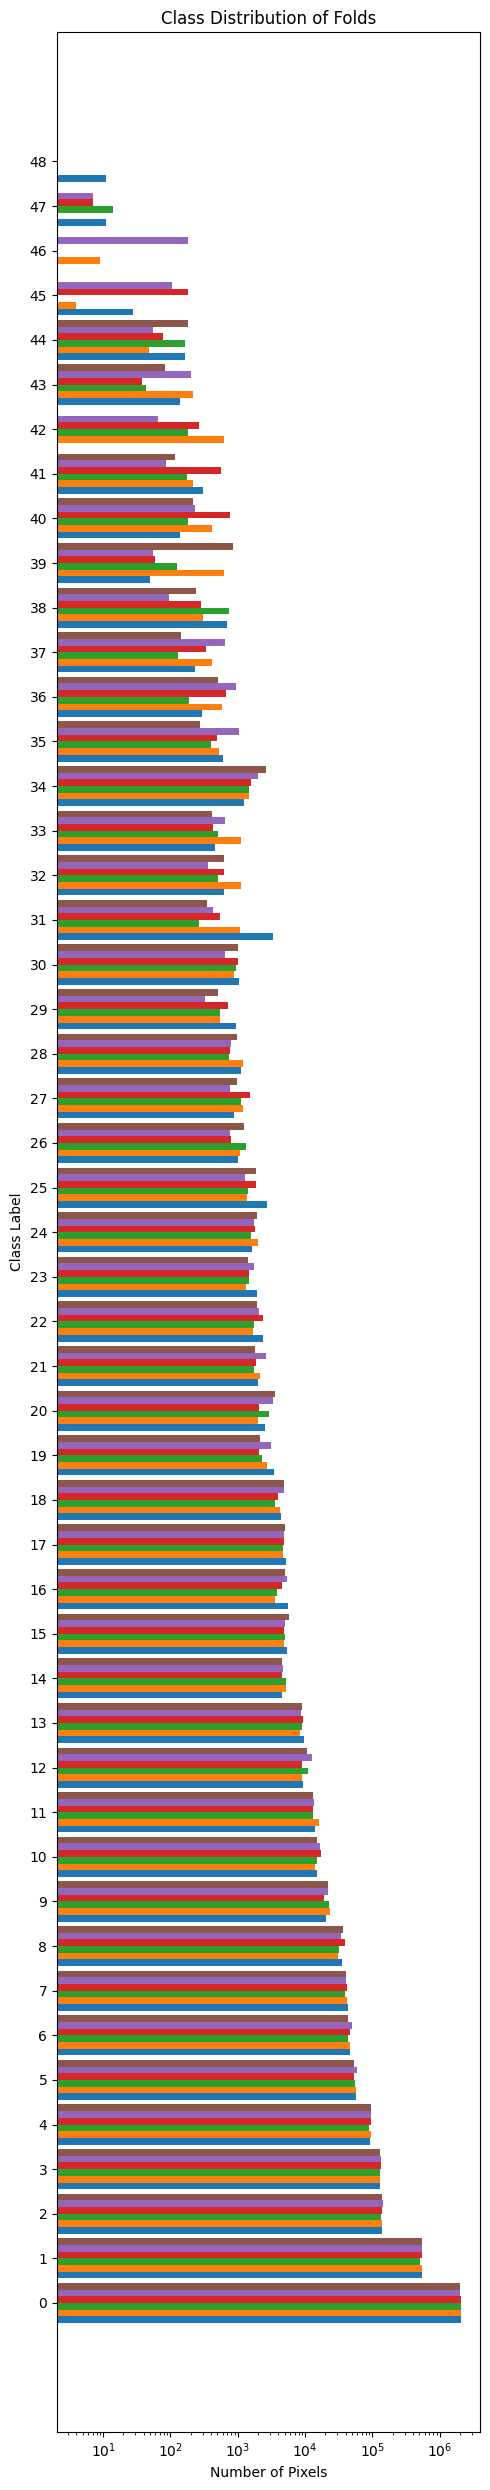

In [23]:
def stratified_split():
    merged_chips = read_chips(params['paths']['stacked_features'])
    mask_chips = read_chips(params['paths']['labels_hierarchy'], include_class_distribution=True)
    field_id_chips = read_chips(params['paths']['field_ids'])

    mask_class_distributions = [mask['class_distribution'] for mask in mask_chips]

    # look for empty chips (where background is the only class)
    empty_indices = []
    for i, class_distribution in enumerate(mask_class_distributions):
        if set(class_distribution.keys()) == set([0]):
            empty_indices.append(i)

    # remove the empty chips
    merged_chips             = [merged_chips[i]             for i in range(len(mask_chips)) if i not in empty_indices]
    mask_chips               = [mask_chips[i]               for i in range(len(mask_chips)) if i not in empty_indices]
    field_id_chips           = [field_id_chips[i]           for i in range(len(mask_chips)) if i not in empty_indices]
    mask_class_distributions = [mask_class_distributions[i] for i in range(len(mask_chips)) if i not in empty_indices]

    # Generate stratified folds
    fold_indices = create_stratified_folds(mask_class_distributions, n_folds=NUMBER_OF_FOLDS, debug=True, transform_mode=params['distribution_transform_mode'])

    # aggregate the class distribution of each fold
    fold_class_distributions = [{} for _ in range(NUMBER_OF_FOLDS)]
    for idx, fold in enumerate(fold_indices):
        for clazz, count in mask_chips[idx]['class_distribution'].items():
            fold_class_distributions[fold][clazz] = fold_class_distributions[fold].get(clazz, 0) + count

    # plot the distributions for analysis
    n_classes = max([max(mask_class_dist.keys()) for mask_class_dist in mask_class_distributions]) + 1
    classes = np.arange(n_classes) # this is also index
    bar_width = 0.15
    fig, ax = plt.subplots(figsize=(5, 25))
    for fold, class_dist in enumerate(fold_class_distributions):
        ax.barh(classes + fold * bar_width, [class_dist.get(clazz, 0) for clazz in classes], bar_width, label=f'Fold {fold}')

    ax.set_xlabel('Number of Pixels') # log scale
    ax.set_xscale('log')
    ax.set_ylabel('Class Label')
    ax.set_yticks(classes + bar_width * (NUMBER_OF_FOLDS - 1) / 2)
    ax.set_yticklabels(classes)
    ax.set_title('Class Distribution of Folds')
    plt.tight_layout()
    plt.show()
    
    # save the chips
    for idx, fold in enumerate(fold_indices):
        for postfix, chip in [
            ("merged", merged_chips[idx]),
            ("mask", mask_chips[idx]),
            ("field_ids", field_id_chips[idx])
        ]:
            filename = f"._chip_{chip['i']:>03}_{chip['j']:>03}_fold_{fold}_{postfix}.tif"
            with rasterio.open(f"{params['paths']['chips']}/{filename}", 'w', **chip['profile']) as dst:
                dst.write(chip['data'])

if SPLIT_MODE == 'stratified':
    os.makedirs(params['paths']['chips'], exist_ok=True)
    stratified_split()

In [64]:
if SPLIT_MODE not in ['band', 'stratified']:
    raise ValueError(f"Invalid split mode: {SPLIT_MODE}")